In [1]:
############################################
BaseDir      = 'IntroDDSJpn/Chap03/'
OutputDir    = '3LassoLarsCV-0903Polynomial/'
FileBaseName = '3LassoLarsCV-0903Polynomial'

* Google Colabかどうかを判別し、このJupyter Notebookのあるディレクトリを特定します。

In [2]:
############################################
import sys
import os
############################################
def IsGoogleColab():
  if 'google.colab' in sys.modules:
    return True
  else:
    return False
############################################
if IsGoogleColab():
  #
  from google.colab import drive
  drive.mount('/content/drive')
  #
  IpynbDir = 'drive/My Drive/Colab Notebooks/' + BaseDir
else:
  #
  IpynbDir =  os.getcwd() + '/'
############################################
print( 'ipynb file path = %s' % IpynbDir )

ipynb file path = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/


* 必要なパッケージを読み込み、ファイルの出力先のディレクトリを用意します。

In [3]:
############################################
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
print('matplotlib Ver.', mpl.__version__)
#
############################################
import numpy as np
import numpy.random as rd
print('numpy      Ver.', np.__version__)
#
############################################
import sklearn as skl
import sklearn.linear_model as lm
import sklearn.preprocessing as prep
from sklearn.model_selection import KFold
print('sklearn    Ver.', skl.__version__)
#
############################################
FilePath = IpynbDir + OutputDir
print( 'FilePath = %s' % FilePath )
#
if( True != os.path.isdir(FilePath) ):
    print('  making %s' % FilePath )
    os.mkdir(FilePath)
else:
    print(' %s is exist.' % FilePath )

matplotlib Ver. 3.9.2
numpy      Ver. 1.26.4
sklearn    Ver. 1.5.2
FilePath = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsCV-0903Polynomial/
  making d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsCV-0903Polynomial/


* 多項式回帰を線形モデル
$$
y_{m}
=
a_{0}
+
\sum_{n=1}^{N}
a_n
x_m^n
$$

* $\boldsymbol{\omega}=(a_1, \cdots, a_n, \cdots, a_N)$

* 計画行列 $\boldsymbol{X}$

$$
\boldsymbol{X}
=
\left(
  \begin{array}{ccccc}
  x_1 & \cdots & x_1^n & \cdots & x_1^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_m & \cdots & x_m^n & \cdots & x_m^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_M & \cdots & x_M^n & \cdots & x_M^N
  \end{array}
\right)
$$

* 線形写像
$$
\boldsymbol{y}=\boldsymbol{X}\boldsymbol{\omega}+a_{0},
$$
$$
\left(
  \begin{array}{c}
  y_1\\
  \vdots \\
  y_m \\
  \vdots \\
  y_M
  \end{array}
\right)
=
\left(
  \begin{array}{c}
  a_0\\
  \vdots \\
  a_0 \\
  \vdots \\
  a_0
  \end{array}
\right)
+
\left(
  \begin{array}{ccccc}
  x_1 & \cdots & x_1^n & \cdots & x_1^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_m & \cdots & x_m^n & \cdots & x_m^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_M & \cdots & x_M^n & \cdots & x_M^N
  \end{array}
\right)
\left(
  \begin{array}{c}
  a_1\\
  \vdots \\
  a_n \\
  \vdots \\
  a_N
  \end{array}
\right)
$$

真値を準備する
* $K=11$とする。
* $a_0=0.2,\,a_1=1.0,\,a_2=0.2,\,a_3=-0.3$ として、それ以外は0とする。
$$
y=0.2+1.0x+0.2x^2-0.3x^3
$$

In [4]:
############################################
# y=0.2+1.0X+0.2X^{2}-0.3X^{3}
#
a_0 = 0.25
#
w_K = 11 - 1
#
w_true = np.zeros((w_K,))
# a_1
w_true[0] = 1.0
# a_2
w_true[1] = 0.2
# a_3
w_true[2] = -0.3
#
print(w_true)

[ 1.   0.2 -0.3  0.   0.   0.   0.   0.   0.   0. ]


切片項と $\omega$ の説明変数スペクトルを描くための準備

In [5]:
###########################################
wspec_x = np.linspace( 0, len(w_true), num=1+len(w_true))
#
# 切片項を先頭に追加
wspec_true = np.concatenate( [[a_0], w_true] )
#
# 1: scrue = np.concatenate( [[a_0], w_true] )
#
# 1: scatter
# 0: vlines
wspec_true_set = [ wspec_true, 1, r'$a_{0}, \vec{\omega}_{\rm true}$', 'red' ]
###########################################

切片項と $\omega$ の説明変数スペクトルを描く関数

In [6]:
###########################################
def SubGrf_wspec( axis, wspec_sets_, title=None ):
  #
  axis.set_xlabel( 'Order' )
  #
  axis.set_ylabel( r'$a_{0}, \vec{\omega}$' )
  #
  int_max = None
  int_min = None
  #
  for wspec_set_ in wspec_sets_:
    #
    wspec_ = wspec_set_[0]
    mode_  = wspec_set_[1] # 0=vlines, 1=scatter
    label_ = wspec_set_[2]
    #
    color_ = wspec_set_[3]
    #
    #######
    L0_ = np.count_nonzero( wspec_ )
    label_ = label_  + r' ($L_{0}$=%d)' % L0_
    #
    #######
    wspec_max = np.amax( wspec_ )
    wspec_min = np.amin( wspec_ )
    #
    #######
    if int_max is not None:
      if wspec_max > int_max:
        int_max = wspec_max
    else:
      int_max = wspec_max
    #
    if int_min is not None:
      if wspec_min < int_min:
        int_min = wspec_min
    else:
      int_min = wspec_min
    #
    #######
    if mode_ == 0:
      # 0: vlines
      axis.vlines( wspec_x, 0, wspec_, label=label_, colors=color_, linewidth=3, linestyles='solid' )
    else:
      # 1: scatter
      axis.scatter( wspec_x, wspec_, label=label_, color=color_, s=30, marker='o' )
    #
    #######
    int_center = (int_max + int_min)/2.0
    int_width  = (int_max - int_min)/2.0
    axis.set_ylim( int_center - 1.2 * int_width, int_center + 1.2 * int_width )
    #
  #
  # zero
  axis.axhline( 0.0, color='black', linewidth=0.5, linestyle='dotted' )
  #
  plt.legend(loc='lower right', fontsize=12)
  #
  if title is not None:
    plt.title( title )
  #
  return
###########################################
def Grf_wspec( wspec_sets_, title=None ):
  #
  plt.rcParams['font.size'] = 16
  #
  fig = plt.figure( figsize=(5,5) )
  fig.subplots_adjust(left=0.18, right=0.97, top=0.95, bottom=0.13)
  #
  ax1 = fig.add_subplot(1,1,1)
  #
  SubGrf_wspec( ax1, wspec_sets_, title=title )
  #
  plt.show()
  #
  return fig

解析データの準備
* データ点数: $M=51$
* $x$値の範囲: $x=[-2.0, +2.0]$

In [7]:
############################################
M = 51 # 201
#
x = np.linspace(-2.0,+2.0, num=M, endpoint=True)
#
print(x)

[-2.   -1.92 -1.84 -1.76 -1.68 -1.6  -1.52 -1.44 -1.36 -1.28 -1.2  -1.12
 -1.04 -0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16
 -0.08  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8
  0.88  0.96  1.04  1.12  1.2   1.28  1.36  1.44  1.52  1.6   1.68  1.76
  1.84  1.92  2.  ]


計画行列$X$の準備
$$
\boldsymbol{X}
=
\left(
  \begin{array}{ccccc}
  x_1 & \cdots & x_1^n & \cdots & x_1^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_m & \cdots & x_m^n & \cdots & x_m^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_M & \cdots & x_M^n & \cdots & x_M^N
  \end{array}
\right)
$$

In [8]:
############################################
X = np.zeros((M, w_K))
#
for k in range(w_K):
    X[:,k] = x**(k+1)
#
print(X)

[[-2.00000000e+00  4.00000000e+00 -8.00000000e+00  1.60000000e+01
  -3.20000000e+01  6.40000000e+01 -1.28000000e+02  2.56000000e+02
  -5.12000000e+02  1.02400000e+03]
 [-1.92000000e+00  3.68640000e+00 -7.07788800e+00  1.35895450e+01
  -2.60919263e+01  5.00964985e+01 -9.61852772e+01  1.84675732e+02
  -3.54577406e+02  6.80788619e+02]
 [-1.84000000e+00  3.38560000e+00 -6.22950400e+00  1.14622874e+01
  -2.10906087e+01  3.88067201e+01 -7.14043650e+01  1.31384032e+02
  -2.41746618e+02  4.44813777e+02]
 [-1.76000000e+00  3.09760000e+00 -5.45177600e+00  9.59512576e+00
  -1.68874213e+01  2.97218616e+01 -5.23104763e+01  9.20664384e+01
  -1.62036931e+02  2.85184999e+02]
 [-1.68000000e+00  2.82240000e+00 -4.74163200e+00  7.96594176e+00
  -1.33827822e+01  2.24830740e+01 -3.77715644e+01  6.34562281e+01
  -1.06606463e+02  1.79098858e+02]
 [-1.60000000e+00  2.56000000e+00 -4.09600000e+00  6.55360000e+00
  -1.04857600e+01  1.67772160e+01 -2.68435456e+01  4.29496730e+01
  -6.87194767e+01  1.09951163e+02

真値データの準備。
$$\boldsymbol{y}=\boldsymbol{X}\boldsymbol{\omega}+a_0$$

In [9]:
############################################
y_true = X @ w_true + a_0
#
print(y_true)

[ 1.45       1.1906464  0.9559712  0.7450528  0.5569696  0.3908
  0.2456224  0.1205152  0.0145568 -0.0731744 -0.1436    -0.1976416
 -0.2362208 -0.2602592 -0.2706784 -0.2684    -0.2543456 -0.2294368
 -0.1945952 -0.1507424 -0.0988    -0.0396896  0.0256672  0.0963488
  0.1714336  0.25       0.3311264  0.4138912  0.4973728  0.5806496
  0.6628     0.7429024  0.8200352  0.8932768  0.9617056  1.0244
  1.0804384  1.1288992  1.1688608  1.1994016  1.2196     1.2285344
  1.2252832  1.2089248  1.1785376  1.1332     1.0719904  0.9939872
  0.8982688  0.7839136  0.65     ]


誤差を重畳させたデータの準備。
* $\boldsymbol{y}_1=\boldsymbol{y}_{\rm true}+{\cal N}(0,\sigma_{1});\;(\sigma_{1}=3.0\times10^{-1})$

In [10]:
############################################
rd.seed(3142)# デモデータなので、同じ結果になるように乱数のシードを設定
############################################
noise = rd.randn(M).reshape(M,)
# ノイズの平均値を0、標準偏差を1に規格化
noise = noise - np.mean( noise )
noise = noise / np.std( noise )
y_1 = y_true + 3.0E-1 * noise # 1.0E-1 * noise

計画行列$X$を標準化する
* 元行列:
$$
\boldsymbol{X}
=
\left(
  \begin{array}{ccccc}
  X_{11} & \cdots & X_{1n} & \cdots & X_{1N} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{m1} & \cdots & X_{mn} & \cdots & X_{mN} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{M1} & \cdots & X_{Mn} & \cdots & X_{MN}
  \end{array}
\right)
$$

* 標準化
```
scalerX = prep.StandardScaler()
scalerX.fit( X )
X_ss = scalerX.transform( X )
```
$$
\tilde{X_{mn}}=\frac{
  X_{mn}-\mu_n
}{
  s_n
}
$$

1. $\mu_n$:  scalerX.mean_[n]
$$
\boldsymbol{\mu}
=
\left(
  \begin{array}{c}
    \mu_{1} \\
    \vdots  \\
    \mu_{n} \\
    \vdots  \\
    \mu_{N}
  \end{array}
\right)
$$

2. $s_n$:    scalerX.scale_[n]

$$
\boldsymbol{s}
=
\left(
  \begin{array}{c}
    s_{1} \\
    \vdots  \\
    s_{n} \\
    \vdots  \\
    s_{N}
  \end{array}
\right)
,
\quad
\boldsymbol{s'}
=
\left(
  \begin{array}{c}
    \frac{1}{s_{1}} \\
    \vdots  \\
    \frac{1}{s_{n}} \\
    \vdots  \\
    \frac{1}{s_{N}}
  \end{array}
\right)
$$


* 標準化された行列:
$$
\tilde{\boldsymbol{X}}
=
\left(
  \begin{array}{ccccc}
  \tilde{X_{11}} & \cdots & \tilde{X_{1n}} & \cdots & \tilde{X_{1N}} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \tilde{X_{m1}} & \cdots & \tilde{X_{mn}} & \cdots & \tilde{X_{mN}} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \tilde{X_{M1}} & \cdots & \tilde{X_{Mn}} & \cdots & \tilde{X_{MN}}
  \end{array}
\right)
$$
1. $\tilde{X_{1n}},\cdots, \tilde{X_{mn}}, \cdots, \tilde{X_{Mn}}$の平均値が0
2. $\tilde{X_{1n}},\cdots, \tilde{X_{mn}}, \cdots, \tilde{X_{Mn}}$の標準偏差が1

に標準化される。

$$
\tilde{\boldsymbol{X}}
=
\left(
  \begin{array}{ccccc}
  \frac{X_{11}-\mu_1}{s_1} & \cdots &
  \frac{X_{1n}-\mu_n}{s_n} & \cdots &
  \frac{X_{1N}-\mu_N}{s_N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \frac{X_{m1}-\mu_1}{s_1} & \cdots &
  \frac{X_{mn}-\mu_n}{s_n} & \cdots &
  \frac{X_{mN}-\mu_N}{s_N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \frac{X_{M1}-\mu_1}{s_1} & \cdots &
  \frac{X_{Mn}-\mu_n}{s_n} & \cdots &
  \frac{X_{MN}-\mu_N}{s_N}
  \end{array}
\right)
$$


* 標準化していない$\boldsymbol{X}$と切片項$a_0$を用いると、

$$\boldsymbol{y}\approx\boldsymbol{X}\boldsymbol{\omega}+a_0$$

* $\tilde{\boldsymbol{X}}$を使って得られた解を$\hat{\tilde{\boldsymbol{\omega}}}$、切片項を$\hat{a}_0$とする。

$$\boldsymbol{y}\approx\tilde{\boldsymbol{X}}\hat{\tilde{\boldsymbol{\omega}}}+\hat{a}_0$$

$$
\left(
  \begin{array}{c}
    y_{1} - \hat{a}_0 \\
    \vdots            \\
    y_{m} - \hat{a}_0 \\
    \vdots            \\
    y_{M} - \hat{a}_0
  \end{array}
\right)
=
\left(
  \begin{array}{ccccc}
  \frac{X_{11}-\mu_1}{s_1} & \cdots &
  \frac{X_{1n}-\mu_n}{s_n} & \cdots &
  \frac{X_{1N}-\mu_N}{s_N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \frac{X_{m1}-\mu_1}{s_1} & \cdots &
  \frac{X_{mn}-\mu_n}{s_n} & \cdots &
  \frac{X_{mN}-\mu_N}{s_N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \frac{X_{M1}-\mu_1}{s_1} & \cdots &
  \frac{X_{Mn}-\mu_n}{s_n} & \cdots &
  \frac{X_{MN}-\mu_N}{s_N}
  \end{array}
\right)
\left(
  \begin{array}{c}
    \hat{\tilde{\omega}}_{1} \\
    \vdots                   \\
    \hat{\tilde{\omega}}_{n} \\
    \vdots                   \\
    \hat{\tilde{\omega}}_{N}
  \end{array}
\right)
$$

$$
=
\left(
  \begin{array}{ccccc}
  X_{11}-\mu_1 & \cdots &
  X_{1n}-\mu_n & \cdots &
  X_{1N}-\mu_N
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{m1}-\mu_1 & \cdots &
  X_{mn}-\mu_n & \cdots &
  X_{mN}-\mu_N
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{M1}-\mu_1 & \cdots &
  X_{Mn}-\mu_n & \cdots &
  X_{MN}-\mu_N
  \end{array}
\right)
\left(
  \begin{array}{c}
    \frac{\hat{\tilde{\omega}}_{1}}{s_{1}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{n}}{s_{n}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{N}}{s_{N}}
  \end{array}
\right)
$$

$$
=
\left(
  \begin{array}{ccccc}
  X_{11} & \cdots &
  X_{1n} & \cdots &
  X_{1N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{m1} & \cdots &
  X_{mn} & \cdots &
  X_{mN}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{M1} & \cdots &
  X_{Mn} & \cdots &
  X_{MN}
  \end{array}
\right)
\left(
  \begin{array}{c}
    \frac{\hat{\tilde{\omega}}_{1}}{s_{1}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{n}}{s_{n}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{N}}{s_{N}}
  \end{array}
\right)
-
\left(
  \begin{array}{ccccc}
  \mu_1 & \cdots &
  \mu_n & \cdots &
  \mu_N
  \end{array}
\right)
\left(
  \begin{array}{c}
    \frac{\hat{\tilde{\omega}}_{1}}{s_{1}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{n}}{s_{n}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{N}}{s_{N}}
  \end{array}
\right)
$$

よって、

$$
\boldsymbol{y}-\hat{a}_0
\approx
\tilde{\boldsymbol{X}}\hat{\tilde{\boldsymbol{\omega}}}
=
\boldsymbol{X}\,
\left(
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
\right)
-
\boldsymbol{\mu}\,\cdot\,
\left(
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
\right)
$$

$$
\therefore\,\,\,
\boldsymbol{y}
\approx
\tilde{\boldsymbol{X}}\hat{\tilde{\boldsymbol{\omega}}}
+\hat{a}_0
=
\boldsymbol{X}\,
\left(
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
\right)
-
\boldsymbol{\mu}\,\cdot\,
\left(
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
\right)
+
\hat{a}_0
$$

一方

$$\boldsymbol{y}=\boldsymbol{X}\boldsymbol{\omega}+a_0$$

なので、

$$\boldsymbol{\omega}
  \,
  \leftarrow
  \,
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
$$

$$a_{0}
  \,
  \leftarrow
  \,
  \hat{a}_0
  -
  \boldsymbol{\mu}\,\cdot\,
  \left(
    \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
  \right)
$$

ここで、$\circ$はアダマール積(Hadamard product)である。

In [11]:
############################################
scalerX = prep.StandardScaler()
scalerX.fit( X )
#
X_ss = scalerX.transform( X )
#
mu_vec     = scalerX.mean_
sdash_vec  = 1 / scalerX.scale_

yデータを描くグラフ

In [12]:
############################################
def SubGrf_ydata( axis, x_data, y_sets, title=None ):
  #
  x_left, x_right = axis.set_xlim( -2.2, 2.2 )
  axis.set_xlabel( r'$x$' )
  #
  y_bot, y_top = axis.set_ylim( -1.5, 2.0 )
  axis.set_ylabel( r'$y$' )
  #
  for y_set in y_sets:
    # [y_data, plottype, label, 'color', size/linewidth, marker/linestyle]
    #   plottype = 0 -> plot
    #   plottype = 1 -> scatter
    if   y_set[1] == 0:
      #
      axis.plot( x_data, y_set[0], label=y_set[2], color=y_set[3], linewidth=y_set[4], linestyle=y_set[5] )
      #
    elif y_set[1] == 1:
      #
      axis.scatter( x_data, y_set[0], label=y_set[2], color=y_set[3], s=y_set[4], marker=y_set[5] )
      #
  #
  plt.legend(loc='lower right', fontsize=12)
  #
  if title is not None:
    plt.title( title )
  #
  return
############################################
def Grf_ydata( x_data, y_sets, title=None ):
  #
  plt.rcParams['font.size'] = 16
  #
  fig = plt.figure( figsize=(5,5) )
  fig.subplots_adjust(left=0.18, right=0.97, top=0.95, bottom=0.13)
  #
  ax1 = fig.add_subplot(1,1,1)
  #
  SubGrf_ydata( ax1, x_data, y_sets, title )
  #
  plt.show()
  #
  return fig

In [13]:
############################################
y_target   = y_1
#
y_true_set   = [ y_true,    0, r'$\vec{y}_{\rm true}$',   'red',   2, 'solid' ]
y_target_set = [ y_target,  1, r'$\vec{y}_{\rm target}$', 'blue', 10, 'o'     ]
#
# ############################################
# y_sets     = [ y_true_set, y_target_set ]
# fig = Grf_ydata( x, y_sets )
# #
# fig.savefig( FilePath + FileBaseName + '-y_target.pdf' )

---
切片項と $\omega$ の説明変数スペクトルを描くための準備

In [14]:
###########################################
wspec_x = np.linspace( 0, len(w_true), num=1+len(w_true))
#
# 切片項を先頭に追加
wspec_true = np.concatenate( [[a_0], w_true] )
#
# 1: scatter
# 0: vlines
wspec_true_set = [ wspec_true, 1, r'$a_{0}, \vec{\omega}_{\rm true}$', 'red' ]
###########################################

切片項と $\omega$ の説明変数スペクトルを描く関数

In [15]:
###########################################
def SubGrf_wspec( axis, wspec_sets_, title=None ):
  #
  axis.set_xlabel( 'Order' )
  #
  axis.set_ylabel( r'$a_{0}, \vec{\omega}$' )
  #
  int_max = None
  int_min = None
  #
  for wspec_set_ in wspec_sets_:
    #
    wspec_ = wspec_set_[0]
    mode_  = wspec_set_[1] # 0=vlines, 1=scatter
    label_ = wspec_set_[2]
    #
    color_ = wspec_set_[3]
    #
    #######
    L0_ = np.count_nonzero( wspec_ )
    label_ = label_  + r' ($L_{0}$=%d)' % L0_
    #
    #######
    wspec_max = np.amax( wspec_ )
    wspec_min = np.amin( wspec_ )
    #
    #######
    if int_max is not None:
      if wspec_max > int_max:
        int_max = wspec_max
    else:
      int_max = wspec_max
    #
    if int_min is not None:
      if wspec_min < int_min:
        int_min = wspec_min
    else:
      int_min = wspec_min
    #
    #######
    if mode_ == 0:
      # 0: vlines
      axis.vlines( wspec_x, 0, wspec_, label=label_, colors=color_, linewidth=3, linestyles='solid' )
    else:
      # 1: scatter
      axis.scatter( wspec_x, wspec_, label=label_, color=color_, s=30, marker='o' )
    #
    #######
    int_center = (int_max + int_min)/2.0
    int_width  = (int_max - int_min)/2.0
    axis.set_ylim( int_center - 1.2 * int_width, int_center + 1.2 * int_width )
    #
  #
  # zero
  axis.axhline( 0.0, color='black', linewidth=0.5, linestyle='dotted' )
  #
  plt.legend(loc='lower right', fontsize=12)
  #
  if title is not None:
    plt.title( title )
  #
  return
###########################################
def Grf_wspec( wspec_sets_, title=None ):
  #
  plt.rcParams['font.size'] = 16
  #
  fig = plt.figure( figsize=(5,5) )
  fig.subplots_adjust(left=0.18, right=0.97, top=0.95, bottom=0.13)
  #
  ax1 = fig.add_subplot(1,1,1)
  #
  SubGrf_wspec( ax1, wspec_sets_, title=title )
  #
  plt.show()
  #
  return fig

---
$\textrm{CV}_{k}(\alpha)$ と $\textrm{CVE}(\alpha)$ を描画するグラフ関数

In [16]:
############################################
def SubGrf_CVk_CVE_SE( axis, dictCV_, interval_=5,
                       on_CV_CVs_k_ = True, on_CV_CVEs_=True, on_CV_SEs_=True,
                       on_CV_alpha_=True, on_CV_1SE_=True, title_=None, title_c=False ):
  #
  #############
  CV_fold_        = dictCV_[ 'CV_fold' ]
  alphas_         = dictCV_[ 'CV_alphas' ]
  CV_CVs_k_       = dictCV_[ 'CV_CVs_k' ]
  CV_CVEs_        = dictCV_[ 'CV_CVEs' ]
  CV_SEs_         = dictCV_[ 'CV_SEs' ]
  CV_alpha_       = dictCV_[ 'CV_alpha' ]
  CV_alpha_idx_   = dictCV_[ 'CV_alpha_idx' ]
  CV_alpha_CVE_   = CV_CVEs_[ CV_alpha_idx_ ]
  CV_alpha_SE_    = CV_SEs_[ CV_alpha_idx_ ]
  CV_coef_        = dictCV_[ 'CV_coef' ]
  CV_coef_L0_     = np.count_nonzero( CV_coef_ )
  CV_1SE_level_   = dictCV_[ 'CV_1SE_level' ]
  CV_1SE_alpha_   = dictCV_[ 'CV_1SE_alpha' ]
  CV_1SE_coef_    = dictCV_[ 'CV_1SE_coef' ]
  CV_1SE_coef_L0_ = np.count_nonzero( CV_1SE_coef_ )
  #
  #############
  axis.set_xscale('log')
  axis.set_xlabel( r'$\alpha$' )
  #
  #############
  ylabel = ''
  if on_CV_CVs_k_:
    ylabel = ylabel + r'${\rm CV}_{k}(\alpha)$ '
  #
  if on_CV_CVEs_:
    if on_CV_SEs_:
      ylabel = ylabel + r'${\rm CVE}(\alpha)\pm{\rm SE}(\alpha)$'
    else:
      ylabel = ylabel + r'${\rm CVE}(\alpha)$'
  #
  axis.set_ylabel(  ylabel, color='black' )
  #
  if on_CV_CVs_k_:
    for fold_ in range(CV_fold_):
      label_CV_CVs_k_ = r'${\rm CV}_{%d}(\alpha)$' % (fold_+1)
      axis.plot( alphas_, CV_CVs_k_[:, fold_], linestyle='dashed', label=label_CV_CVs_k_, linewidth=1.5 )
  #
  if on_CV_CVEs_:
    axis.plot( alphas_, CV_CVEs_, linestyle='solid', linewidth=1.5, color='red',label=r'${\rm CVE}(\alpha)$')
  #
  # CVEの1SE
  if on_CV_SEs_:
    axis.errorbar( CV_alpha_, CV_alpha_CVE_, yerr=CV_alpha_SE_, linestyle='solid', linewidth=4, color='red')
  #
  #############
  # interval 間隔
  if on_CV_SEs_:
    axis.errorbar( alphas_, CV_CVEs_, yerr=CV_SEs_, linestyle='solid', errorevery=interval_,
                   linewidth=1.5, color='red',label=r'CVE$\pm$1SE')
  #
  #############
  if on_CV_alpha_:
    CV_alpha_label_ = r'$\hat{\alpha}_{\rm CVE}$=%.3E r($L_{0}$=%d)' % (CV_alpha_, CV_coef_L0_)
    # axis.axvline( CV_alpha_, color='black', linestyle='dashed', linewidth=1.5, label=CV_alpha_label_ )
    axis.axvline( CV_alpha_, color='black', linestyle='dashed', linewidth=1.5 )
    #
    (axis_bot, axis_top) = axis.set_ylim()
    #
    axis.text( CV_alpha_, axis_top - 0.05*(axis_top-axis_bot),
               CV_alpha_label_, fontsize=10, rotation=90,
               horizontalalignment='center', verticalalignment='top',
               color='white', backgroundcolor='black', zorder=2.0)
  #
  #############
  if on_CV_1SE_:
    CV_1SE_level_label_ = r'CVE($\hat{\alpha}_{\rm CVE}$)+1SE($\hat{\alpha}_{\rm CVE}$)'
    # axis.axhline( CV_1SE_level_, color='green', linestyle='dotted', linewidth=1.5, label=CV_1SE_level_label_ )
    axis.axhline( CV_1SE_level_, color='green', linestyle='dotted', linewidth=1.5 )
    #
    (axis_left, axis_right) = axis.set_xlim()
    #
    axis.text( axis_left, CV_1SE_level_,
               CV_1SE_level_label_, fontsize=10, rotation=00,
               horizontalalignment='left', verticalalignment='center',
               color='green', backgroundcolor='white', zorder=2.0)
    #
    CV_1SE_alpha_label_ = r'$\hat{\alpha}_{\rm 1SE}$=%.3E ($L_{0}$=%d)' % (CV_1SE_alpha_, CV_1SE_coef_L0_)
    # axis.axvline( CV_1SE_alpha_, color='black', linestyle='dashed', linewidth=1.5, label=CV_1SE_alpha_label_ )
    axis.axvline( CV_1SE_alpha_, color='green', linestyle='dashed', linewidth=1.5)
    #
    (axis_bot, axis_top) = axis.set_ylim()
    #
    axis.text( CV_1SE_alpha_, axis_top - 0.05*(axis_top-axis_bot),
               CV_1SE_alpha_label_, fontsize=10, rotation=90,
               horizontalalignment='center', verticalalignment='top',
               color='white', backgroundcolor='green', zorder=2.0)
  #
  #############
  if title_ is None:
    title_ = 'LassoLarsCV(), '
    if on_CV_CVs_k_:
      title_ = title_ + r'${\rm CV}_{k}(\alpha)$ '
    #
    if on_CV_CVEs_:
      if on_CV_SEs_:
        title_ = title_ + r'${\rm CVE}(\alpha)\pm{\rm SE}(\alpha)$'
      else:
        title_ = title_ + r'${\rm CVE}(\alpha)$'
  #
  if title_c:
    title_ = '(c) ' + title_
  #
  plt.title( title_ )
  #
  plt.legend( loc='upper left',  fontsize=12 )
  #
  return
  #
############################################
def Grf_CVk_CVE_SE( dictCV_, interval_=5,
                    on_CV_CVs_k_ = True, on_CV_CVEs_=True, on_CV_SEs_=True,
                    on_CV_alpha_=True, on_CV_1SE_=True, title_=None  ):
  #
  ########################
  plt.rcParams["font.size"] = 16
  #
  fig = plt.figure(figsize=(6,5))
  #
  fig.subplots_adjust(left=0.15, right=0.97, top=0.92, bottom=0.12, wspace=0.3)
  #
  ########################
  ########################
  # MSE, L0、RMSDを描画するグラフ
  ax1 = fig.add_subplot( 1, 1, 1 )
  #
  SubGrf_CVk_CVE_SE( ax1, dictCV_, interval_=interval_,
                    on_CV_CVs_k_ = on_CV_CVs_k_, on_CV_CVEs_=on_CV_CVEs_, on_CV_SEs_=on_CV_SEs_,
                    on_CV_alpha_=on_CV_alpha_, on_CV_1SE_=on_CV_1SE_, title_=title_ )
  #
  plt.show()
  #
  return fig

---
交差検証

(1) データの分割

まずデータセット $\boldsymbol{D}=\{\cdots,(x_m,y_m),\cdots\}$  $(m=1,\cdots,M)$ を $\color{LightBlue}{(M-M_{k})個}$ の$\color{LightBlue}{訓練データ\boldsymbol{D}_k^\textrm{tr}}$ と、$\color{Red}{M_{k}個}$ の $\color{Red}{検証データ\boldsymbol{D}_k^\textrm{te}}$ に分割（$\boldsymbol{D}=\{\color{LightBlue}{\boldsymbol{D}_k^\textrm{tr}}, \color{Red}{\boldsymbol{D}_k^\textrm{te}}\}$）する。

$$
    \boldsymbol{D}
    =
    \left\{
        \begin{array}{lll}
            \color{LightBlue}{
                \boldsymbol{D}_k^\textrm{tr}
                :=
                \left\{
                    \cdots, (x_m, y_m), \cdots
                \right\}
            }
            , &
            \color{LightBlue}{
                \boldsymbol{y}_k^\textrm{tr}
                :=
                \big\{
                    \underbrace{
                        \cdots, y_m, \cdots
                    }_{(M-M_{k})個}
                \big\}
            }
            , &
            \color{LightBlue}{
                m \notin
            }
            \color{Red}{
                \boldsymbol{D}_k^\textrm{te}
            }
            \\
            \color{Red}{
                \boldsymbol{D}_k^\textrm{te}
                :=
                \left\{
                    \cdots, (x_m, y_m), \cdots
                \right\}
            }
            , &
            \color{Red}{
                \boldsymbol{y}_k^\textrm{te}
                :=
                \big\{
                    \overbrace{
                        \cdots, y_m, \cdots
                    }^{M_{k}個}
                \big\}
            }
            , &
            \color{Red}{
                m \in
            }
            \color{Red}{
                \boldsymbol{D}_k^\textrm{te}
            }
        \end{array}
    \right.    
$$

このデータ分割は、以下の規則に従って行う。

* 全データ点からランダムな位置（シャッフル）で検証データを抜粋して分割する。

* $K$-fold交差検証では、$K~(k=1,\cdots,K)$ 組の $\color{LightBlue}{\boldsymbol{D}_k^\textrm{tr}}$,  $\color{Red}{\boldsymbol{D}_k^\textrm{te}}$ を用意する。

* 全データ点（$m=1,\cdots,M$）を $k=1,\cdots,K$ で、一度だけ、かつ、必ず $\color{Red}{検証データ\boldsymbol{D}_k^\textrm{te}}$ として選択する。

(2) 訓練データによる学習

$\color{LightBlue}{訓練データ\boldsymbol{D}_k^\textrm{tr}}$ を学習して、ある $\alpha$ におけるスパース解 $\color{LightBlue}{\hat{\boldsymbol{\omega}}_k^\textrm{tr}(\alpha)}$ をLASSO法を用いて得る。

$$
    \color{LightBlue}{
    \hat{\boldsymbol{\omega}}_{k}^\textrm{tr}(\alpha)
    =
    \textrm{argmin}_{\boldsymbol{\omega}_{k}^\textrm{tr}}
    \left[
        \frac{1}{2(M-M_{k})}
        \left\|
            \boldsymbol{y}_{k}^\textrm{tr}
            -
            \mathbf{X}_{k}^\textrm{tr}
            \,
            \boldsymbol{\omega}_{k}^\textrm{tr}
        \right\|_{2}^{2}
        +
        \alpha
        \left\|
            \boldsymbol{\omega}_{k}^\textrm{tr}
        \right\|_{1}
    \right]    
    },
$$

ここで $\color{LightBlue}{\mathbf{X}_{k}^\textrm{tr}}$ は、$\color{LightBlue}{訓練データ \boldsymbol{y}_{k}^\textrm{tr}}$ に対応する（検証データ分を抜いた）計画行列である。

(3) 検証データによる予測誤差の評価

得た $\color{LightBlue}{\hat{\boldsymbol{\omega}}_{k}^\textrm{tr}(\alpha)}$ を用いて、 $\color{Red}{検証データ \boldsymbol{D}_k^\textrm{te}}$ を予測できるかを、予測の検定誤差 $\textrm{CV}_{k}(\alpha)$ を次式で評価する。

$$
    \textrm{CV}_{k}(\alpha)
    =
    \frac{1}{2M_{k}}
    \left\|
        \color{Red}{\boldsymbol{y}_{k}^\textrm{te}}
        -
        \color{Red}{\mathbf{X}_{k}^\textrm{te}}
        \color{LightBlue}{\hat{\boldsymbol{\omega}}_{k}^\textrm{tr}(\alpha)}
    \right\|_2^2
$$

$\textrm{CV}_{k}(\alpha)$ は $\alpha$ に応じて以下のように振る舞う。

* $\alpha$が大き過ぎる場合（よりスパースな解）
    
  $\color{LightBlue}{訓練データ}$の学習で得られる $\color{LightBlue}{\hat{\boldsymbol{\omega}}_{k}^\textrm{tr}(\alpha)}$ には、非ゼロ要素数が少なく勉強不足で、データを説明する主要素が不足している。そのため、$\color{Red}{検証データ}$を予測できず $\textrm{CV}_{k}(\alpha)$ は大きい。

* $\alpha$を小さくすると

  勉強不足が解消され、$\color{LightBlue}{\hat{\boldsymbol{\omega}}_{k}^\textrm{tr}(\alpha)}$ が $\color{Red}{検証データ}$ を予測できるようになり、$\textrm{CV}_{k}(\alpha)$ は改善（減少）する。

* $\alpha$が小さすぎる場合（過学習）

  $\color{LightBlue}{\hat{\boldsymbol{\omega}}_{k}^\textrm{tr}(\alpha)}$ が $\color{LightBlue}{訓練データ}$ に含まれるランダムノイズまでも過学習してしまう。しかし $\color{LightBlue}{訓練データ}$ と $\color{Red}{検証データ}$ にそれぞれ重畳するノイズは無相関で、予測誤差が劣化する。

$\color{LightBlue}{訓練データ}$ と $\color{Red}{検証データ}$ を1組として、各 $k\;(=1,\cdots,K)$ 組において、$\textrm{CV}_{k}(\alpha)$ を評価する。


(4) 交差検証誤差

しかしデータの分割はランダムに行うため、各 $k\;(=1,\cdots,K)$ 組で $\textrm{CV}_{k}(\alpha)$ はばらついてしまうし、解析をやり直しても、分割に用いられる乱数が異なるため、それでもばらつく。そのため、$K$~$(k=1,\cdots,K)$組で次式の様に平均した交差検証誤差(CVE)を評価する。

$$
    \textrm{CVE}(\alpha)
    =
    \frac{1}{K}
    \sum_{k=1}^{K}
    \textrm{CV}_{k}(\alpha)
$$

予測誤差を最小化する意図の場合、次式の様に、交差検証誤差を最小化する $\hat{\alpha}_\textrm{CVE}$ を推定（モデル選択）する。

$$
    \hat{\alpha}_\textrm{\tiny{}CVE}
    =
    \textrm{argmin}_{\alpha}
    \textrm{CVE}(\alpha)
$$


(5) 交差検証誤差の標準誤差

各 $k\;(=1,\cdots,K)$組での$\textrm{CV}_{k}(\alpha)$ のばらつきを表す、$\textrm{CV}_{1}(\alpha),\cdots,\textrm{CV}_{K}(\alpha)$ の標本分散 $\sigma_\textrm{CV}^{2}(\alpha)$ は、次式で定義され、

$$
    \sigma_\textrm{CV}^{2}(\alpha)
    =
    \frac{1}{K-1}
    \sum_{k=1}^{K}
    \left[
        \textrm{CV}_{k}(\alpha)
        -
        \textrm{CVE}(\alpha)
    \right]^{2}
$$

平均である $\textrm{CVE}(\alpha)$ の標準誤差 $\textrm{SE}(\alpha)$ は、次式で定義される。

$$
    \textrm{SE}(\alpha)
    =
    \frac{
        \sigma_\textrm{CV}(\alpha)    
    }{\sqrt{K}}
$$

(6) 1SE則

(4)による $\alpha$ の推定は、予測誤差を最小化する意図で用いられるが、その推定された交差検証誤差 $\textrm{CVE}(\hat{\alpha}_\textrm{CVE})$ も $\textrm{SE}(\hat{\alpha}_\textrm{\tiny{}CVE})$ の誤差がある。ならばその誤差程度を許容して、より大きな $\alpha$を選択して、次式に基づき、スパースつまり簡素にデータを説明するモデルを選択する発見的方法（数学的根拠はない）がある。これは1SE則(One srandard error rule)と呼ばれる。

$$
    \hat{\alpha}_\textrm{1SE}
    =
    \textrm{argmax}_{\alpha}
    \textrm{CVE}(\alpha)
    ,
$$
$$    \textrm{subject to }
    \textrm{CVE}(\alpha)
    \leq
    \textrm{CVE}(\hat{\alpha}_\textrm{CVE})
    +
    \textrm{SE}(\hat{\alpha}_\textrm{CVE})
$$

---
シャッフルさせるために
* sklearn.model_selection.KFold
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

1. 引数
    * n_splitsint (5): 分割数
    * shuffle (False) : シャッフルするか否か

---
LassoLarsCV
* sklearn.linear_model.LassoLarsCV
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLarsCV.html

1. 引数
    * cv (5): データ分解の方法
    
    シャッフルするために、KFold関数を次のように、shuffle=Trueを指定して用いる。
    ```
    cv = KFold(n_splits=fold, shuffle=True)
    ```
    * fit_intercept (True): 切片を計算するか否か

2. 返値
    * alpha_: CVEが最小化される$\hat{\alpha}$
    * coef_: その時の$\hat{\boldsymbol{\omega}}(\hat{\alpha})$
    * cv_alphas_: 探索した$\alpha$のテーブル
    * mse_path_: $\alpha$のテーブルの各CVセットの平均誤差

In [17]:
############################################
dictCV = {}
############################################
CV_fold = 5
dictCV[ 'CV_fold' ] = CV_fold
#
############################################
# CV
CV = lm.LassoLarsCV( cv=KFold( n_splits=CV_fold, shuffle=True ), max_iter=100000)
CV.fit(X_ss, y_target)
#
# CV_alphas_ = CV.alphas_ # for LasoCV()
CV_alphas_ = CV.cv_alphas_ # for LassoLarsCV()
dictCV[ 'CV_alphas' ] = CV_alphas_
print( 'CV_alphas_ = \n', CV_alphas_ )
#
CV_alpha_  = CV.alpha_
print( 'CV_alpha_           = ', CV_alpha_ )
dictCV[ 'CV_alpha' ] = CV_alpha_
#
CV_alpha_idx_ = np.where( CV_alphas_ == CV_alpha_ )[0][0]
print( 'CV_alpha_idx_       = ', CV_alpha_idx_ )
dictCV[ 'CV_alpha_idx' ] = CV_alpha_idx_
#
##############
# 回帰係数
CV_coef_   = CV.coef_
print( 'L0(CV_coef_)        = ', np.count_nonzero( CV_coef_ ) )
print( 'CV_coef_            = \n', CV_coef_ )
dictCV[ 'CV_coef' ] = CV_coef_
#
CV_intercept_ = CV.intercept_
print( 'CV_intercept_       = \n', CV_intercept_ )
dictCV[ 'CV_intercept' ] = CV_intercept_
#
##############
# オリジナルの係数に戻す
CV_coef_org_      = sdash_vec * CV_coef_
CV_intercept_org_ = CV_intercept_ - mu_vec @ CV_coef_org_
CV_wspec_ = np.concatenate( [[CV_intercept_org_], CV_coef_org_] )
dictCV[ 'CV_wspec' ] = CV_wspec_
#
##############
# yの回帰
CV_yreg_      = X_ss @ CV_coef_ + CV_intercept_
dictCV[ 'CV_yreg' ] = CV_yreg_
CV_yreg_RMSD_ = np.std( CV_yreg_ - y_target )
print( 'CV_yreg_RMSD_       = ', CV_yreg_RMSD_ )
dictCV[ 'CV_yreg_RMSD' ] = CV_yreg_RMSD_
#
############
# CV_{k}(\alpha)
CV_CVs_k_     = CV.mse_path_
dictCV[ 'CV_CVs_k' ] = CV_CVs_k_
#
############
# CV_CVs_k_ の平均としてCVEを求める
CV_CVEs_      = np.mean( CV_CVs_k_, axis=1 )
print( 'CV_CVEs_            = \n', CV_CVEs_ )
dictCV[ 'CV_CVEs' ] = CV_CVEs_
#
# print( 'argmin(CV_CVEs_)    = ', np.argmin( CV_CVEs_ ) )
CV_minCVE_    = np.amin(CV_CVEs_)
dictCV[ 'CV_minCVE' ] = CV_minCVE_
# print( 'min(CV_CVEs_)       = \n', np.amin(CV_CVEs_ ) )
# print( 'CV_CVEs_[]          = \n', CV_CVEs_[CV_alpha_idx_] )
#
############
# CVEの標準誤差
CV_temp_  = np.zeros_like( CV_CVs_k_ )
#
for k in range( CV_fold ):
  CV_temp_[:, k] = (CV_CVs_k_[:, k] - CV_CVEs_)**2
#
CV_SEs_ = np.sqrt( np.sum( CV_temp_, axis=1 ) / ( ( CV_fold - 1 ) * CV_fold ) )
dictCV[ 'CV_SEs' ] = CV_SEs_
# print( 'CV_SEs_             = \n', CV_SEs_ )
#
############
# 1SE level
CV_1SE_level_ = CV_minCVE_ + CV_SEs_[CV_alpha_idx_]
print( 'CV_1SE_level_       = ', CV_1SE_level_ )
dictCV[ 'CV_1SE_level' ] = CV_1SE_level_
#
############
# 1SE level の alpha
# for idx_ in np.arange(CV_alpha_idx_):
# LassoLarsCV()の alphas_ は、alphaが昇順に並んでいる
for idx_ in np.arange(CV_alpha_idx_, (len(CV_alphas_)-1) ):
  alpha_1   = CV_alphas_[idx_]
  alpha_2   = CV_alphas_[idx_+1]
  CV_CVEs_1 = CV_CVEs_[idx_]
  CV_CVEs_2 = CV_CVEs_[idx_+1]
  #
  if ((CV_CVEs_1 - CV_1SE_level_)*(CV_CVEs_2 - CV_1SE_level_)) <=0 :
    break
#
print( 'CV_1SE_level_ = %.6E' % CV_1SE_level_ )
print( '  1 = %.6f, %.6E' % (alpha_1, CV_CVEs_1) )
print( '  2 = %.6f, %.6E' % (alpha_2, CV_CVEs_2) )
#
ln_alpha_1 = np.log(alpha_1)
ln_alpha_2 = np.log(alpha_2)
#
ln_alpha = ln_alpha_1 + (CV_1SE_level_ - CV_CVEs_1) / (CV_CVEs_2 - CV_CVEs_1) * (ln_alpha_2 - ln_alpha_1)
#
CV_1SE_alpha_ = np.exp( ln_alpha )
print( 'CV_1SE_alpha_ = %.6f' % CV_1SE_alpha_ )
dictCV[ 'CV_1SE_alpha' ] = CV_1SE_alpha_
#
############
# 1SE level の alpha での回帰
lasso = lm.Lasso( alpha=CV_1SE_alpha_, max_iter=100000)
lasso.fit(X_ss, y_target)
#
CV_1SE_coef_ = lasso.coef_
print( 'L0(CV_1SE_coef_)        = ', np.count_nonzero( CV_1SE_coef_ ) )
print( 'CV_1SE_coef_            = \n', CV_1SE_coef_ )
dictCV[ 'CV_1SE_coef' ] = CV_1SE_coef_
#
CV_1SE_intercept_ = lasso.intercept_
print( 'CV_1SE_intercept_       = \n', CV_1SE_intercept_ )
dictCV[ 'CV_1SE_intercept' ] = CV_1SE_intercept_
#
##############
# オリジナルの係数に戻す
CV_1SE_coef_org_      = sdash_vec * CV_1SE_coef_
CV_1SE_intercept_org_ = CV_1SE_intercept_ - mu_vec @ CV_1SE_coef_org_
CV_1SE_wspec_ = np.concatenate( [[CV_1SE_intercept_org_], CV_1SE_coef_org_] )
dictCV[ 'CV_1SE_wspec' ] = CV_1SE_wspec_
#
##############
# 1SE level の alpha でのyの回帰
CV_1SE_yreg_      = X_ss @ CV_1SE_coef_ + CV_1SE_intercept_
dictCV[ 'CV_1SE_yreg' ] = CV_1SE_yreg_
CV_1SE_yreg_RMSD_ = np.std( CV_1SE_yreg_ - y_target )
dictCV[ 'CV_1SE_yreg_RMSD' ] = CV_1SE_yreg_RMSD_
print( 'CV_1SE_yreg_RMSD       = ', CV_1SE_yreg_RMSD_ )
#

CV_alphas_ = 
 [0.00000000e+00 6.85421208e-07 3.03354218e-06 3.15727890e-06
 6.14892862e-06 7.26386729e-06 8.28470320e-06 1.04056244e-05
 1.20547911e-05 1.24130785e-05 1.31749498e-05 1.32732162e-05
 1.74763001e-05 1.93098010e-05 2.02804336e-05 2.39401043e-05
 3.27474166e-05 3.53985113e-05 3.78929541e-05 3.98286961e-05
 5.26020189e-05 5.84447811e-05 6.11360557e-05 6.54695126e-05
 7.20375593e-05 7.43128478e-05 7.48316750e-05 8.05238191e-05
 8.65441520e-05 8.73663709e-05 8.92036633e-05 9.43654837e-05
 9.96642777e-05 1.03600866e-04 1.41978710e-04 1.47702308e-04
 1.56969599e-04 1.63231197e-04 1.74779335e-04 1.92328489e-04
 2.08480497e-04 2.11951421e-04 2.29813092e-04 2.43399221e-04
 2.53164046e-04 2.59645537e-04 3.09348186e-04 4.23705177e-04
 6.39214159e-04 7.08036663e-04 8.19939737e-04 8.55258836e-04
 8.56438995e-04 9.21159012e-04 9.30292167e-04 1.01205433e-03
 1.03559224e-03 1.13656634e-03 2.37847684e-03 2.89883580e-03
 2.96113945e-03 3.09897503e-03 3.57618828e-03 3.65408379e-03
 3.768376

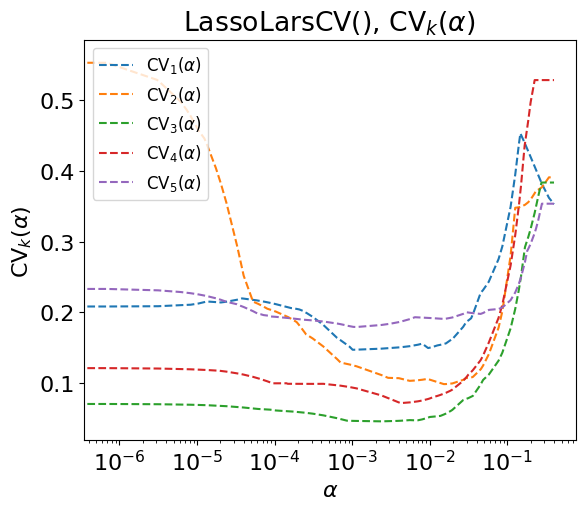

In [18]:
############################################
# CV_k(\alpha)のグラフ
fig = Grf_CVk_CVE_SE( dictCV, on_CV_CVEs_=False, on_CV_SEs_=False, on_CV_alpha_=False, on_CV_1SE_=False )
#
pdfFName = FilePath + FileBaseName + '-CV_k-01.pdf'
fig.savefig( pdfFName )

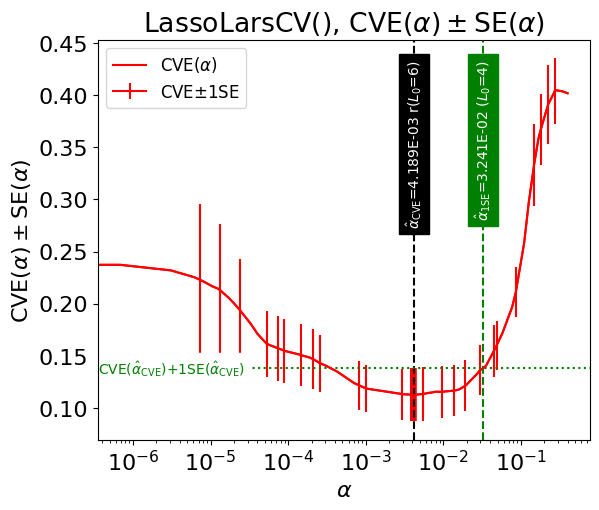

In [19]:
############################################
# CVE(\alpha)のグラフ
fig = Grf_CVk_CVE_SE( dictCV, on_CV_CVs_k_=False )
#
pdfFName = FilePath + FileBaseName + '-CVE-01.pdf'
fig.savefig( pdfFName )

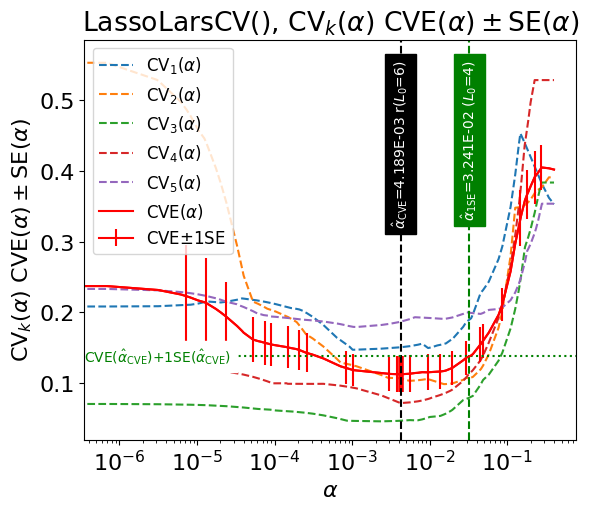

In [20]:
############################################
# CV_k(\alpha), CVE(\alpha)のグラフ
fig = Grf_CVk_CVE_SE( dictCV )
#
pdfFName = FilePath + FileBaseName + '-CV_k-CVE-01.pdf'
fig.savefig( pdfFName )

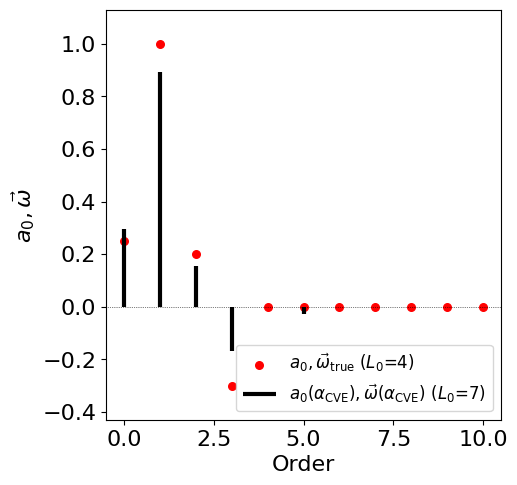

In [21]:
###########################################
wspec_CVE_set = [ dictCV['CV_wspec'],     0, r'$a_{0}(\alpha_{\rm CVE}), \vec{\omega}(\alpha_{\rm CVE})$', 'black' ]
wspec_1SE_set = [ dictCV['CV_1SE_wspec'], 0, r'$a_{0}(\alpha_{\rm 1SE}), \vec{\omega}(\alpha_{\rm 1SE})$', 'green' ]
###########################################
wspec_sets = [ wspec_true_set, wspec_CVE_set ]
###########################################
fig = Grf_wspec( wspec_sets )

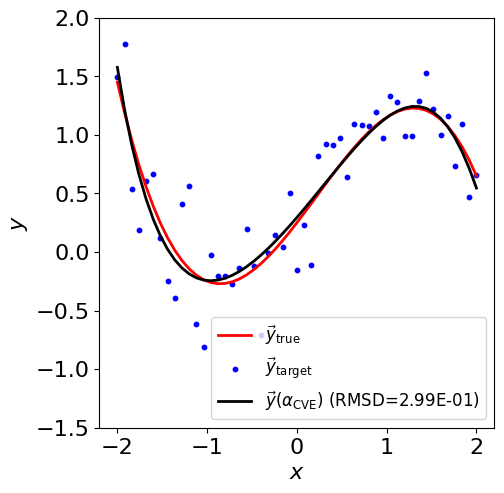

In [22]:
############################################
y_true_set   = [ y_true,    0, r'$\vec{y}_{\rm true}$',   'red',   2, 'solid' ]
y_target_set = [ y_target,  1, r'$\vec{y}_{\rm target}$', 'blue', 10, 'o'     ]
#
y_CVE_label  = r'$\vec{y}(\alpha_{\rm CVE})$ (RMSD=%.2E)' % dictCV[ 'CV_yreg_RMSD' ]
y_CVE_set    = [ dictCV[ 'CV_yreg' ], 0, y_CVE_label,   'black',   2, 'solid' ]
#
y_1SE_label  = r'$\vec{y}(\alpha_{\rm 1SE})$ (RMSD=%.2E)' % dictCV[ 'CV_1SE_yreg_RMSD' ]
y_1SE_set    = [ dictCV[ 'CV_1SE_yreg' ], 0, y_1SE_label,   'green',   2, 'solid' ]
#
############################################
y_sets     = [ y_true_set, y_target_set, y_CVE_set ]
fig = Grf_ydata( x, y_sets )

---
まとめのグラフを描く関数

In [23]:
dictCV.keys()

dict_keys(['CV_fold', 'CV_alphas', 'CV_alpha', 'CV_alpha_idx', 'CV_coef', 'CV_intercept', 'CV_wspec', 'CV_yreg', 'CV_yreg_RMSD', 'CV_CVs_k', 'CV_CVEs', 'CV_minCVE', 'CV_SEs', 'CV_1SE_level', 'CV_1SE_alpha', 'CV_1SE_coef', 'CV_1SE_intercept', 'CV_1SE_wspec', 'CV_1SE_yreg', 'CV_1SE_yreg_RMSD'])

In [24]:
############################################
def Grf_summary( dictCV_, bool1SE=False ):
  #
  ##########################################
  CV_fold_      = dictCV_[ 'CV_fold' ]
  CV_alphas_    = dictCV_[ 'CV_alphas' ]
  CV_alpha_     = dictCV_[ 'CV_alpha' ]
  CV_alpha_idx_ = dictCV_[ 'CV_alpha_idx' ]
  CV_1SE_alpha_ = dictCV_[ 'CV_1SE_alpha' ]
  CV_CVs_k_     = dictCV_[ 'CV_CVs_k'     ]
  CV_CVEs_      = dictCV_[ 'CV_CVEs'      ]
  CV_minCVE_    = dictCV_[ 'CV_minCVE'    ]
  CV_SEs_       = dictCV_[ 'CV_SEs'       ]
  CV_1SE_level_ = dictCV_[ 'CV_1SE_level' ]
  #
  if bool1SE:
    # 1SE result
    coef_      = dictCV_[ 'CV_1SE_coef'      ]
    intercept_ = dictCV_[ 'CV_1SE_intercept' ]
    wspec_     = dictCV_[ 'CV_1SE_wspec'     ]
    yreg_      = dictCV_[ 'CV_1SE_yreg'      ]
    yreg_RMSD_ = dictCV_[ 'CV_1SE_yreg_RMSD' ]
    #
    yreg_label = r'$\vec{y}(\alpha_{\rm 1SE})$ (RMSD=%.2E)' % yreg_RMSD_
    yreg_set   = [ yreg_, 0, yreg_label,   'green',   2, 'solid' ]
    title1 = r'(a) LassoLarsCV(), 1SE: $\vec{y}_{\rm True}, \vec{y}, \hat{\vec{y}}(\alpha_{\rm 1SE})$'
    #
    wspec_set = [ wspec_, 0, r'$a_{0}(\alpha_{\rm 1SE}), \vec{\omega}(\alpha_{\rm 1SE})$', 'green' ]
    title2 = r'(b) LassoLarsCV(), 1SE: $\vec{\omega}_{\rm true}, \hat{\vec{\omega}}(\alpha_{\rm 1SE})$'
    #
  else:
    # CVE result
    coef_      = dictCV_[ 'CV_coef'      ]
    intercept_ = dictCV_[ 'CV_intercept' ]
    wspec_     = dictCV_[ 'CV_wspec'     ]
    yreg_      = dictCV_[ 'CV_yreg'      ]
    yreg_RMSD_ = dictCV_[ 'CV_yreg_RMSD' ]
    #
    yreg_label = r'$\vec{y}(\alpha_{\rm CVE})$ (RMSD=%.2E)' % yreg_RMSD_
    yreg_set   = [ yreg_, 0, yreg_label,   'black',   2, 'solid' ]
    title1 = r'(a) LassoLarsCV(), CVE: $\vec{y}_{\rm True}, \vec{y}, \hat{\vec{y}}(\alpha_{\rm CVE})$'
    #
    wspec_set = [ wspec_, 0, r'$a_{0}(\alpha_{\rm CVE}), \vec{\omega}(\alpha_{\rm CVE})$', 'black' ]
    title2 = r'(b) LassoLarsCV(), CVE: $\vec{\omega}_{\rm true}, \hat{\vec{\omega}}(\alpha_{\rm CVE})$'
  #
  ##########################################
  # Graph
  ##########################################
  plt.rcParams['font.size'] = 16
  #
  fig = plt.figure( figsize=(18,5) )
  fig.subplots_adjust(left=0.06, right=0.99, top=0.91, bottom=0.12, wspace=0.20)
  #
  ##########################################
  y_true_set   = [ y_true,   0, r'$\vec{y}_{\rm true}$',   'red',   2, 'dashed' ]
  y_target_set = [ y_target, 1, r'$\vec{y}_{\rm target}$', 'blue', 10, 'o'      ]
  #
  y_sets    = [ y_true_set, y_target_set, yreg_set ]
  ###########
  ax_y = fig.add_subplot(1, 3, 1)
  SubGrf_ydata( ax_y, x, y_sets, title=title1 )
  #
  ##########################################
  wspec_true_set   = [ wspec_true, 1, r'$a_{\rm 0, true}, \vec{\omega}_{\rm true}$', 'red' ]
  #
  wspec_sets = [ wspec_true_set, wspec_set ]
  ###########
  ax_wspec = fig.add_subplot(1, 3, 2)
  SubGrf_wspec( ax_wspec, wspec_sets, title=title2 )
  #
  ##########################################
  ax_CVk = fig.add_subplot(1, 3, 3)
  SubGrf_CVk_CVE_SE( ax_CVk, dictCV_, title_c=True )
  #
  plt.show()
  #
  return fig

---
交差検証のまとめのグラフ

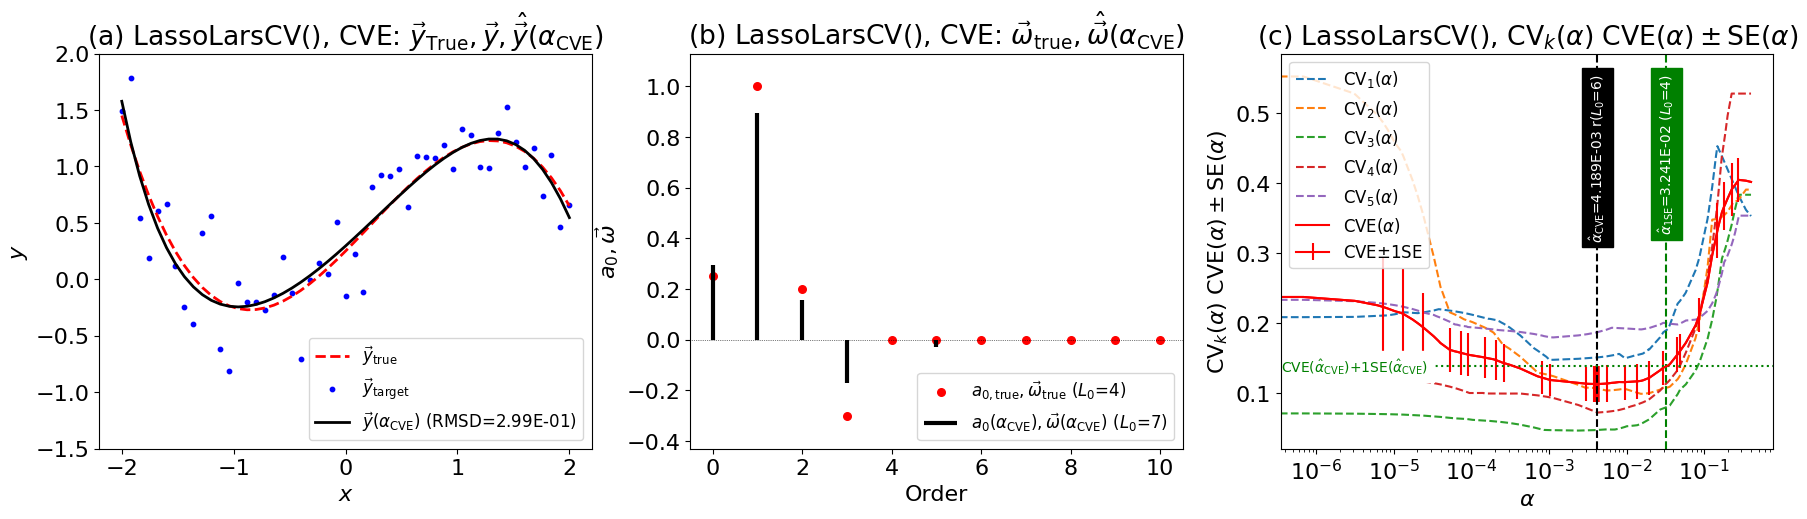

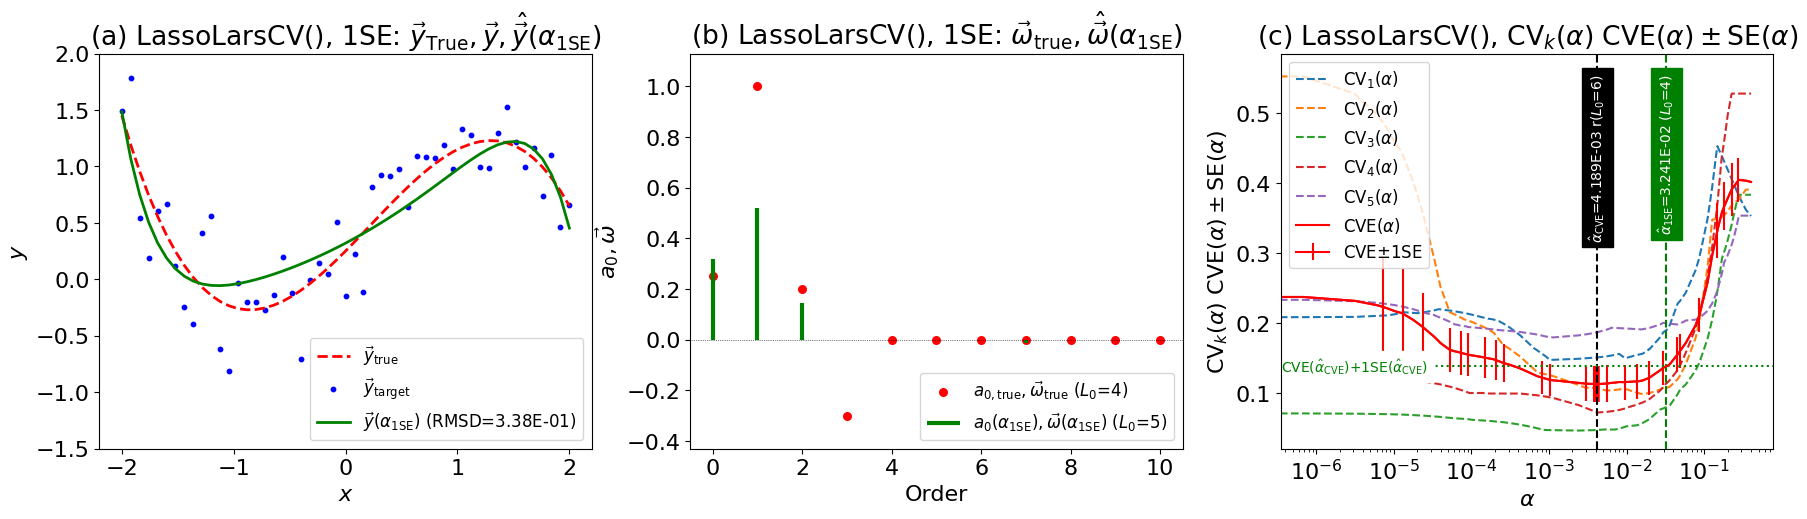

In [25]:
############################################
fig = Grf_summary( dictCV, bool1SE=False )
#
pdfFName = FilePath + FileBaseName + '-summary-CVE-01.pdf'
fig.savefig( pdfFName )
#
############################################
fig = Grf_summary( dictCV, bool1SE=True )
#
pdfFName = FilePath + FileBaseName + '-summary-1SE-01.pdf'
fig.savefig( pdfFName )